In [3]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bangkit Final Project
## Crowd Counting

This notebook contains step-by-step process in building and evaluating model for crowd counting.
<br/>

By:
*   Harrianto Sunaryan
*   Iyas Yustira
*   Muhammad Farrel M
*   Rinda Nur Hafizha



## Load the imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

import scipy
from scipy import spatial
from scipy import ndimage

#import tensorflow as tf
import keras
from keras.layers import Conv2D, Average, MaxPooling2D, Flatten,concatenate, Input, Dense, UpSampling2D, Conv2DTranspose, ReLU, Activation, BatchNormalization,Lambda
from keras.models import Model
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.optimizers import Adam, Nadam
from keras.applications import vgg16
import keras.backend as K

## Load Dataset
In this part, we load the dataset, ground truth, density map, and labels.\
The original dataset can be found in https://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html \
The density maps was generated with Geometry-adaptive kernel. We can generate it from images in mall dataset on this [notebook](https://github.com/Yustira/crowd-counting/blob/master/Generate_density.ipynb) \
The images dataset are normalized into the interval [0,1]

### Run this code only when you are using Colab
This code will download dataset needed to colab's temporary storage

#### Install PyDrive

#### Google Drive Authentication

#### Download the file from the link

##### Download images file in `.npy` format from this [link](https://drive.google.com/file/d/1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF/view)

##### Download ground truth file for images in the dataset from this [link](https://drive.google.com/file/d/1F8MSiZ974Hta6gZcex9DFvGwbhA2u3s8/view)

##### Download density map file that has been generated for images in the dataset from this [link](https://drive.google.com/file/d/1-1JXmD6sumzJcATFQzm9Yq7CCDZ2K7cT/view)

##### Download labels for images in the dataset from this [link](https://drive.google.com/file/d/1NYHK2AcLmm-sHpZWFR5vn_ejxX3KB7Mz/view)

### Load dataset from file

In [6]:
import imutils
import  cv2
from imutils import paths
import matplotlib.pyplot as plt
def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []
	# loop over the image paths
	for imagePath in imagePaths:
		image = cv2.imread(imagePath)
		data.append(image)
	return np.array(data, dtype="float32")

In [7]:
import glob
import imutils
import  cv2
import os
from imutils import paths
def load_gt(datasetPath):
  path_sets = [datasetPath]
  img_paths = []
  for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
  print(len(img_paths))
  data=[]
  img_paths = eval('img_paths')
  for img_path in tqdm(img_paths):
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground_truth').replace('IMG_', 'GT_IMG_'))
    gt = pts["image_info"][0, 0][0, 0][0]
    data.append(gt)
  return data

In [9]:
from numpy import genfromtxt
from scipy.io import loadmat
image = '/content/drive/My Drive/images/images'
images = load_dataset(image)
print(np.shape(images))
label = ('/content/drive/My Drive/labels.csv')
labels = genfromtxt(label, delimiter=',')
print(np.shape(labels))
images_gt = load_gt(image)
images_density=np.load('/content/drive/My Drive/images_density.npy')
print('ok')

(200, 480, 640, 3)


  0%|          | 0/200 [00:00<?, ?it/s]

(200, 2)
200


100%|██████████| 200/200 [01:11<00:00,  2.79it/s]


ok


## Data Preview

In [10]:
images=images/255

### Images

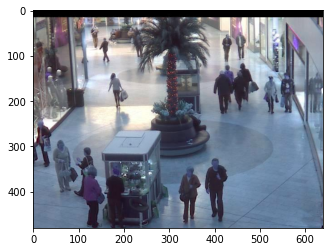

In [11]:
img=plt.imshow(images[24])

### Images + Ground Truth (Annotated Frame)

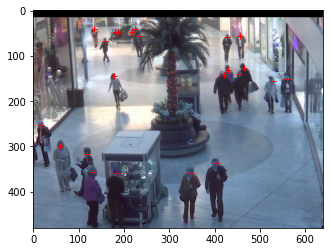

In [12]:
img=plt.imshow(images[24])
img=plt.plot(images_gt[24][:,0],images_gt[24][:,1],'r+')

### Images + Density Map

number of people: 22.99


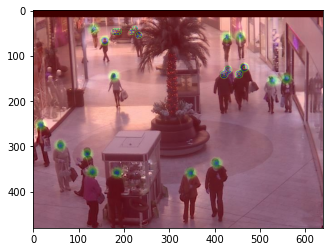

In [13]:
plt.imshow(images[24])
plt.imshow(images_density[24],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(images_density[24]/1000))

## Create Model

### Import VGG16 as Baseline
Set the input shape for our model\
Creating baseline model with VGG16

In [14]:
# image size per image patch
size=(96,128)
input_shape=(size[0],size[1],3)
baseline_vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58892288/58889256 [==============================] - 0s 0us/step


### Main Model Architecture

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [16]:
def Crowd_CNN(input_shape=input_shape):
    
    input_flow=Input(input_shape)
    base_filter=8
    
    x_vgg=baseline_vgg.get_layer(index=1)(input_flow)
    for i in range(2,10):
        x_vgg=baseline_vgg.get_layer(index=i)(x_vgg)
        
    
    
    x_1=Conv2D(base_filter*16,9,padding='same',activation='relu')(x_vgg)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(1,1,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    
    
    x_2=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_vgg)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(1,1,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_3=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_vgg)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_4=Conv2D(base_filter*4,3,padding='same',activation='relu')(x_vgg)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*2,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    
    
    x_conct=concatenate([x_1,x_2,x_3,x_4])
    x_fel=Flatten()(x_conct)
    x_fel=Dense(base_filter*8,activation='relu')(x_fel)
    x_fel=Dense(4,activation='softmax')(x_fel)
    
    x=Lambda(lambda x: x*(1+x_fel))(x_conct)

    
    x=Conv2D(base_filter*2,5,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=concatenate([x,x_conct])
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter*2, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter,1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(1,1,padding='same',activation='relu')(x)
    
    model=Model(inputs=input_flow,outputs=x)    
    
    return model
    
    
    
    
    
    
    


### SSIM and Euclidean Loss + Custom MAE metrics

In [17]:
def ssim_loss(y_true, y_pred, c1=0.01**2, c2=0.03**2):
    weights_initial = np.multiply(
        cv2.getGaussianKernel(12, 1.5),
        cv2.getGaussianKernel(16, 1.5).T
    )
    weights_initial = weights_initial.reshape(*weights_initial.shape, 1, 1)
    weights_initial = K.cast(weights_initial, tf.float32)

    mu_F = tf.nn.conv2d(y_pred, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_Y = tf.nn.conv2d(y_true, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_F_mu_Y = tf.multiply(mu_F, mu_Y)
    mu_F_squared = tf.multiply(mu_F, mu_F)
    mu_Y_squared = tf.multiply(mu_Y, mu_Y)

    sigma_F_squared = tf.nn.conv2d(tf.multiply(y_pred, y_pred), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_squared
    sigma_Y_squared = tf.nn.conv2d(tf.multiply(y_true, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_Y_squared
    sigma_F_Y = tf.nn.conv2d(tf.multiply(y_pred, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_mu_Y

    ssim = ((2 * mu_F_mu_Y + c1) * (2 * sigma_F_Y + c2)) / ((mu_F_squared + mu_Y_squared + c1) * (sigma_F_squared + sigma_Y_squared + c2))

    return 1 - tf.reduce_mean(ssim, axis=[1, 2, 3])


def ssim_eucli_loss(y_true, y_pred, alpha=0.0025):
    ssim = ssim_loss(y_true, y_pred)
    eucli = mean_squared_error(y_true, y_pred)
    loss = eucli + alpha * ssim
    return loss

def mae_cnt(labels,preds):
    cnt_label=K.sum(labels)
    cnt_pred=K.sum(preds)
    return K.abs(cnt_label-cnt_pred)

### Define the Model

In [18]:
lr=1e-5
model=Crowd_CNN()
# model.load_weights("Crowd-CNN")
Optimizer=Nadam(lr)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 128, 64)  1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 128, 64)  36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 64, 64)   0           block1_conv2[1][0]               
_______________________________________________________________________________________

## Data Pre-Processing

### Normalize images value
Divide them by 255 so it will have value with range [0,1]

In [ ]:
images = images/255

### Create Train and Validation Set
The dataset is divided into training and validation set with 85% : 15% ratio \
X (input) is images and Y (label) is its corresponding density map

In [20]:
X_train, X_val, Y_train, Y_val=train_test_split(images,images_density,test_size=0.15,random_state=70)
print(X_train.shape)

(170, 480, 640, 3)


### Add dimension for label

In [21]:
Y_train=np.expand_dims(Y_train,-1)
Y_val=np.expand_dims(Y_val,-1)

### Function to generate patches of images

Function `get_patch` will generate patches of image from a single full image that will be used for training and evaluation process


In [22]:
def get_patch(X,Y):
    x_patch=np.zeros([3*X.shape[0],size[0],size[1],3])
    y_patch=np.zeros([3*Y.shape[0],size[0],size[1],1])
    
    for i in range(X.shape[0]):
        for j in range(3):
    
            x1=np.random.randint(0,X.shape[1]-size[0]-1)
            y1=np.random.randint(0,X.shape[2]-size[1]-1)
            x2=size[0]+x1
            y2=size[1]+y1

            x_patch[3*i+j]=X[i,x1:x2,y1:y2,:]
            y_patch[3*i+j]=Y[i,x1:x2,y1:y2,:]
    
    return x_patch,y_patch

## Training
The training process is done with 2 epochs without train the VGG16 layers and 2 epoch with trainable VGG16 layers

### Training with 2 epochs without training the VGG16 layers

In [23]:
for i in model.layers[:10]:
    i.trainable=False
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt],experimental_run_tf_function=False)

In [24]:
for i in range(2):
    x_patch,y_patch=get_patch(X_train,Y_train)
    x_patch_val,y_patch_val=get_patch(X_val,Y_val)
    
    model.fit(x_patch,y_patch,batch_size=1,epochs=1,validation_data=(x_patch_val,y_patch_val))

Train on 510 samples, validate on 90 samples
510/510 [==============================] - ETA: 0s - loss: 1.0881 - mae_cnt: 4206.4487WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
510/510 [==============================] - 262s 514ms/sample - loss: 1.0881 - mae_cnt: 4206.4487 - val_loss: 0.8099 - val_mae_cnt: 3599.4048
Train on 510 samples, validate on 90 samples
510/510 [==============================] - 259s 508ms/sample - loss: 0.5625 - mae_cnt: 2852.4026 - val_loss: 0.4885 - val_mae_cnt: 3156.2031


### Training with 2 epochs with training the VGG16 layers

In [25]:
for i in model.layers[:10]:
    i.trainable=True
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

In [26]:
for i in range(2):
    x_patch,y_patch=get_patch(X_train,Y_train)
    x_patch_val,y_patch_val=get_patch(X_val,Y_val)
    
    model.fit(x_patch,y_patch,batch_size=1,epochs=1,validation_data=(x_patch_val,y_patch_val))

Train on 510 samples, validate on 90 samples
510/510 [==============================] - 410s 804ms/sample - loss: 0.4111 - mae_cnt: 1774.1694 - val_loss: 0.2839 - val_mae_cnt: 1706.2557
Train on 510 samples, validate on 90 samples
510/510 [==============================] - 412s 808ms/sample - loss: 0.3288 - mae_cnt: 1388.6160 - val_loss: 0.3273 - val_mae_cnt: 1280.9542


## Evaluation and Result

### Pre-process the evaluation data
This data is used for evaluating model with data per patches

In [27]:
x_patch,y_patch=get_patch(X_val,Y_val)
print(len(y_patch))

90


### Function for predicting input
Function `full_eval` is used for doing prediction based on model that has been built. The input is full image and will return the predicted density map

In [28]:
def full_eval(x,smooth=False):
    y=np.zeros([480,640])
    for i in range(0,480,size[0]):
        for j in range(0,640,size[1]):
            y[i:i+size[0],j:j+size[1]]+=model.predict(x[:,i:i+size[0],j:j+size[1],:])[0,:,:,0]
    if smooth:
        y=ndimage.filters.gaussian_filter(y, 2, mode='constant')
    return y

### Prediction for image patch

Variable `e` is the index of the data in the array of image patches\
The result of the prediction is saved on variable `ex_val`

Predicted Number of people: 1.92
Exact Number of people: 2.00


<Figure size 432x288 with 0 Axes>

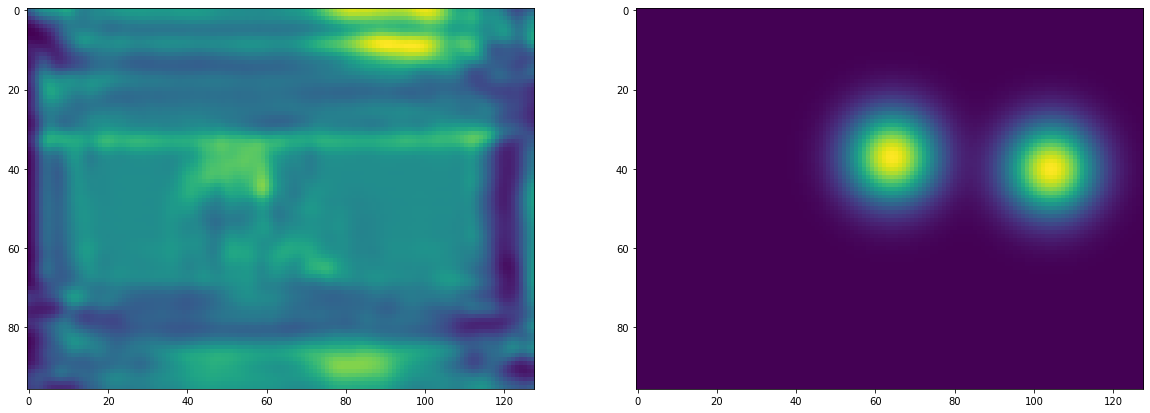

In [34]:
e=32
ex_val=ndimage.filters.gaussian_filter(model.predict(x_patch[e:e+1]),2)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 
axarr[0].imshow(ex_val[0,:,:,0])
axarr[1].imshow(y_patch[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(ex_val)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y_patch[e])/1000))


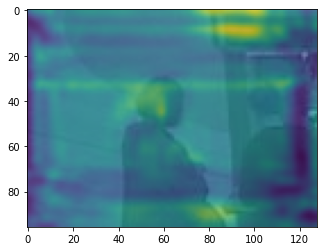

In [35]:

plt.imshow(x_patch[e,:,:,:])
plt.imshow(ex_val[0,:,:,0],alpha=0.7)

### Prediction for full image
Variable `e` is the index of the data in the array of image patches\
The result of the prediction is saved on variable `ex_val`

Predicted Number of people: 46.06
Exact Number of people: 33.00


<Figure size 432x288 with 0 Axes>

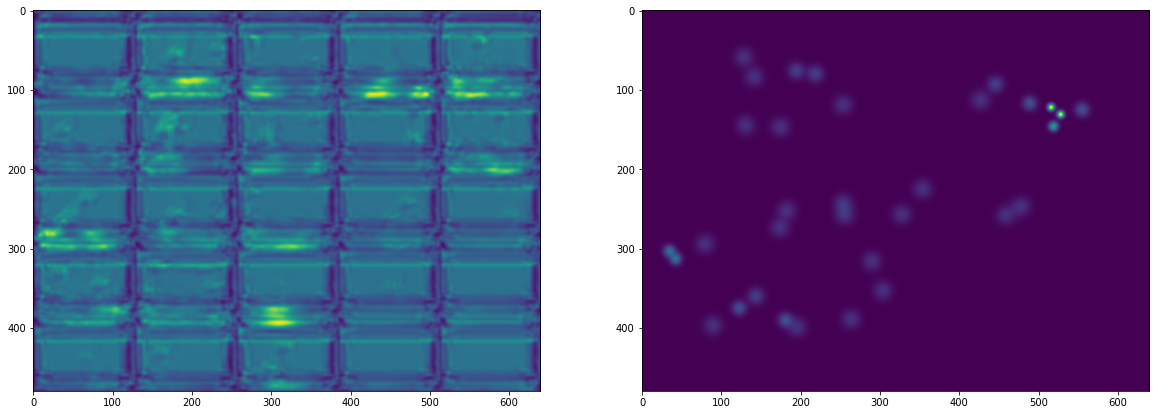

In [38]:
e=16
ex_val=full_eval(X_val[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 
axarr[0].imshow(ex_val)
axarr[1].imshow(Y_val[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(ex_val)/1000))
print('Exact Number of people: %4.2f' %(np.sum(Y_val[e])/1000))


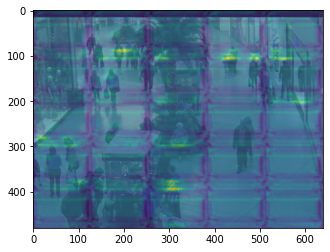

In [39]:
plt.imshow(X_val[e,:,:,:])
plt.imshow(ex_val,alpha=0.7)

### Model Evaluation on Validation set for full images
The evaluation is done by calculating the Mean Absolute Error (MAE) for the full images on validation set

In [40]:
full_patch=np.zeros([X_val.shape[0],2])

In [41]:
error=0
for i in tqdm(range(X_val.shape[0])):
    full_patch[i,0]=np.sum(Y_val[i:i+1])/1000
    full_patch[i,1]=(np.sum(full_eval(X_val[i:i+1],smooth=False)))/1000
    error+=np.abs(full_patch[i,0]-full_patch[i,1])
print('Mean Absolute Error for the Full-Images: %4.2f' %(error/X_val.shape[0]))

100%|██████████| 30/30 [02:21<00:00,  4.72s/it]

Mean Absolute Error for the Full-Images: 21.23


Text(0.5, 1.0, 'Comparison for Full Images')

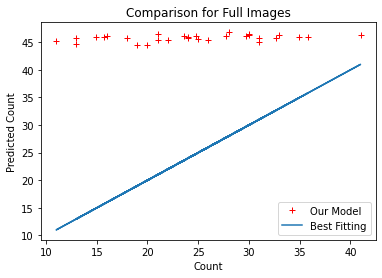

In [42]:
plt.plot(full_patch[:,0],full_patch[:,1],'r+')
plt.plot(full_patch[:,0],full_patch[:,0])
plt.xlabel('Count')
plt.ylabel('Predicted Count')
plt.legend(['Our Model','Best Fitting'])
plt.title('Comparison for Full Images')

### Model Evaluation on Validation set per image patches
The evaluation is done by calculating the Mean Absolute Error (MAE) for the image patches on validation set

In [43]:
eval_patch=np.zeros([x_patch.shape[0],2])

In [44]:
error_patch=0
for i in tqdm(range(x_patch.shape[0])):
    eval_patch[i,0]=np.sum(y_patch[i:i+1])/1000
    eval_patch[i,1]=np.sum(model.predict(x_patch[i:i+1]))/1000
    error_patch+=np.abs((eval_patch[i,0]-eval_patch[i,1]))
print('Mean Absolute Error for the Random Patches in Images: %4.2f' %(error_patch/x_patch.shape[0]))

100%|██████████| 90/90 [00:17<00:00,  5.16it/s]

Mean Absolute Error for the Random Patches in Images: 1.50


Text(0.5, 1.0, 'Comparison for Random Patches in Images')

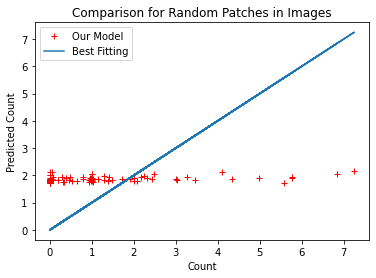

In [45]:
plt.plot(eval_patch[:,0],eval_patch[:,1],'r+')
plt.plot(eval_patch[:,0],eval_patch[:,0])
plt.xlabel('Count')
plt.ylabel('Predicted Count')
plt.legend(['Our Model','Best Fitting'])
plt.title('Comparison for Random Patches in Images')

In [46]:
model.save_weights("/content/drive/My Drive/Crowd-CNN")